###Learning with pre-trained model parameter as initial weight

It's effective to use public pre-trained model file in learning if the model and your model have same layers.
It's known empirically that former layers in neural network obtains abstract features and later layers / last layer obstains specific features for target. That's why models can share former layer-parameters without depending on prediction target and it saves time, computer resources and empirical techniques in training.

<br>

Major techniques about learning with pre-trained model parameters:
- Initialize net-parameters using trained model and update the prameters with target dataset WITHOUT fixing each net-parameters
- Initialize net-pamameters using trained model and train update only parameters in last layer and fix parameters in other layers. 

#### Setup

In [0]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import sys

In [0]:
batch_size = 64

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
    ]
)

train_dataset = datasets.ImageFolder(root='./oxford_pet_dataset/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = datasets.ImageFolder(root='./oxford_pet_dataset/val', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

classes = train_dataset.classes
num_classes = len(classes)

In [0]:
# model starting with random-initialized parameter
no_pretrain_model = models.vgg16(pretrained=False)

# model with flexible pre-trained parameter
flex_param_model = models.vgg16(pretrained=True)
flex_param_model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, num_classes)
)

# model with fixed pre-trained parameter except for last layer
fix_param_model = models.vgg16(pretrained=True)
removed = list(fix_param_model.classifier.children())[:-1]
fix_param_model.classifier = torch.nn.Sequential(*removed, nn.Linear(4096, num_classes))
for param in fix_param_model.parameters():
    param.requires_grad = False
for param in fix_param_model.classifier[6].parameters():
    param.requires_grad = True

# generate model_list, criterion, optimizer_list
model_list = [no_pretrain_model, flex_param_model, fix_param_model]
criterion = nn.CrossEntropyLoss()
optimizer_list = [
    optim.Adam(model.parameters(), lr = 0.0001) for model in 
    [no_pretrain_model, flex_param_model, fix_param_model.classifier[6]]
]

for model in model_list:
    model.cuda()
    
num_models = len(model_list)

In [0]:
plotdata = {
    'loss': [[] for i in range(num_models)],
    'acc': [[] for i in range(num_models)],
}

def train():
    for model in model_list:
        model.train()

    num_iter = len(train_loader)
    cur_iter = 0
    for data, targets in train_loader:
        cur_iter += 1
        sys.stdout.write("\r%d/%d" % (cur_iter, num_iter))
        sys.stdout.flush()
        
        data, targets = data.cuda(), targets.cuda()
        data, targets = Variable(data), Variable(targets)

        for model, optimizer, plotloss in zip(model_list, optimizer_list, plotdata['loss']):
            output = model(data)
            optimizer.zero_grad()
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            plotloss.append(loss.data[0])

def validate():
    for model in model_list:
        model.eval()
        
    total = [0 for i in range(num_models)]
    correct = [0 for i in range(num_models)]
    
    print(" Validation")
    for data, targets in val_loader:
        data, targets = data.cuda(), targets.cuda()
        data = Variable(data, volatile=True)

        for idx, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
            output = model(data)
            _, pred = torch.max(output.data, 1)
            total[idx] += data.size(0)
            correct[idx] += (pred==targets).sum()
    
    for i in range(len(model_list)):
        acc = int(100 * correct[i] / total[i])
        plotdata['acc'][i].append(acc)

epocs = 20
for i in range(epocs):
    print("Train epoch %d:" % i)
    train()
    validate()

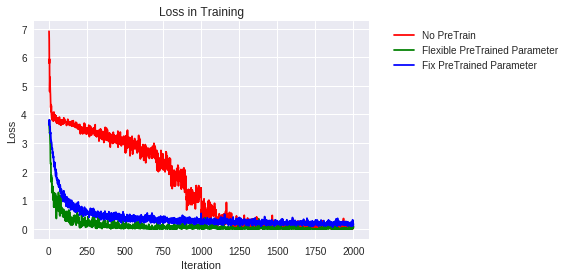

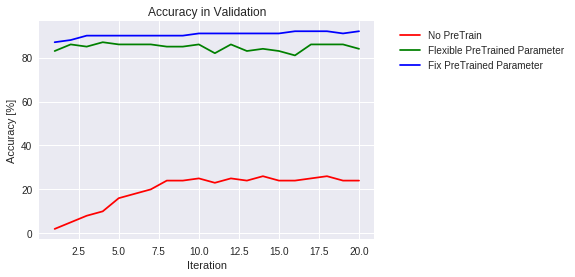

In [0]:
colors = ['red', 'green', 'blue']
labels = ["No PreTrain", "Flexible PreTrained Parameter", "Fix PreTrained Parameter"]

plt.figure()
plt.title("Loss in Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
for i in range(num_models):
    y = plotdata['loss'][i]
    x = range(1, len(y)+1)
    c = colors[i]
    l = labels[i]
    plt.plot(x, y, color=c, label=l)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure()
plt.title("Accuracy in Validation")
plt.xlabel("Iteration")
plt.ylabel("Accuracy [%]")
for i in range(num_models):
    y = plotdata['acc'][i]
    x = range(1, len(y)+1)
    c = colors[i]
    l = labels[i]
    plt.plot(x, y, color=c, label=l)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()